In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
#from logs import enable_logging, logging 
from importlib import reload
import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries
from nnpde.functions import helpers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
)


# Set the optimizer, you have to play with lr: if too big nan
optim = torch.optim.SGD(net.parameters(), lr = 1e-6)
##optim = torch.optim.Adadelta(net.parameters())
#optim = torch.optim.Adam(net.parameters(), lr=1e-6)
#optim = torch.optim.ASGD(net.parameters())
# SGD seems much faster

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[ 0.2274, -0.0089, -0.1305],
          [ 0.0541,  0.2024, -0.0456],
          [ 0.2344, -0.1296,  0.3106]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.0194, -0.2598, -0.2926],
          [ 0.1117,  0.0224,  0.0932],
          [ 0.2278,  0.0886,  0.3332]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.2591, -0.1149, -0.0808],
          [-0.0338,  0.2629,  0.1549],
          [-0.2991, -0.1965, -0.1655]]]], requires_grad=True)


In [4]:
class dirichlet_problem:
    """A class for setting a problem instance"""
    
    def __init__(self, B_idx=None, B=None, forcing_term=None, k=20, k_ground_truth = 1000, initial_u=None, domain_type="Square", N=16):
        
        if B_idx is None:
            self.B_idx, self.B = geometries.square_geometry(N)
        else:
            self.B_idx = B_idx
            self.B = B
            
        if forcing_term is None:
            self.forcing_term = torch.zeros(1, 1, N, N)
        else:
            self.forcing_term = forcing_term
        
        if initial_u is None:
            self.initial_u = torch.rand(1, 1, N, N, requires_grad=True)
        else:
            self.initial_u = initial_u
        
        self.k = k 
        
        # Initial_u_jacobi is different, it must not require grad
        self.initial_u_jacobi = torch.zeros(1, 1, N, N)
        self.k_ground_truth = k_ground_truth
        self.ground_truth = im.jacobi_method(self.B_idx, self.B, self.forcing_term, self.initial_u_jacobi, self.k_ground_truth)


In [5]:
class train_iterativeMethod:
    """A class to obtain the optimal weights"""
    def __init__(self, net, problem_instances_list, batch_size=1, learning_rate = 1e-6,max_iters = 1000, tol = 1e-6, k_range = [1, 20],N=16):
        
        self.net = net
        self.learning_rate = learning_rate
        optim = torch.optim.SGD(net.parameters(), learning_rate)

        self.batch_size = batch_size
        self.max_iters = max_iters
        self.tol = tol
        self.k_range = k_range
        
        self.problem_instances_list = problem_instances_list
        self.nb_problem_instances = len(problem_instances_list)
        self.T = helpers.get_T(N)
        self.H = helpers.build_diagH_from_net(net,N)
        self.N = N
        
    def _optimization_step_(self):
            net.zero_grad()
            loss = torch.zeros(1)

            u_list = [None] * self.batch_size

            # Sample problem_instances
            problem_idx = np.random.choice(np.arange(self.nb_problem_instances), self.batch_size, replace = 0)

            for i in range(self.batch_size):

                idx = problem_idx[i]
                problem_instance = self.problem_instances_list[idx]

                B_idx = problem_instance.B_idx
                B = problem_instance.B
                f = problem_instance.forcing_term
                initial_u = problem_instance.initial_u
                k = problem_instance.k
                ground_truth = problem_instance.ground_truth

                # Compute the solution with the updated weights      
                u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)
                
                # Compute the spectral norm and set the loss to infinity if spectral norm > 1
                spectral_norm = helpers.calculate_spectral_radius(self.T,self.H)
                ex = 0
                
                if spectral_norm > 1:
                    ex = np.nan_to_num(np.inf)

                # Define the loss, CHECK if it is correct wrt paper
                loss = loss + F.mse_loss(ground_truth, u_list[i]) + ex
                
                # Backpropagation
                loss.backward(retain_graph =  False)

                # SGD step
                optim.step()
                
                
    def _optimal_weights_(self):
        losses = []
        prev_total_loss = 0 
        #print(prev_total_loss)
        for n_iter in range(self.max_iters):
            
            self._optimization_step_()

            total_loss = helpers.compute_loss(net, problem_instances_list,self.N)

            # Exit optimization 
            if total_loss.item() <= self.tol or total_loss.item() - prev_total_loss < self.tol:
                break


            # Store lossses for visualization
            losses.append(total_loss.item())
            prev_total_loss = total_loss.item()
            
        return losses

    
   
        

In [6]:
# Initialize list of problem instances
nb_problem_instances = 50
problem_instances_list = [None] * nb_problem_instances

# Define train dimension
N = 16

# Initialize f: we use a zero forcing term for training
f = torch.zeros(1, 1, N, N)

# For each problem instance define number of iteration to perform to obtain the solution
k = np.random.randint(1, 20, nb_problem_instances)

for i in range(nb_problem_instances):
     problem_instances_list[i] = dirichlet_problem(k = k[i])

Train using the class

In [7]:
train_net = train_iterativeMethod(net, problem_instances_list, max_iters=10)
losses = train_net._optimal_weights_()

In [8]:
for name, param in train_net.net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[ 0.2274, -0.0089, -0.1305],
          [ 0.0541,  0.2024, -0.0456],
          [ 0.2344, -0.1296,  0.3106]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.0194, -0.2598, -0.2926],
          [ 0.1117,  0.0224,  0.0932],
          [ 0.2278,  0.0886,  0.3332]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.2591, -0.1149, -0.0808],
          [-0.0338,  0.2629,  0.1549],
          [-0.2991, -0.1965, -0.1655]]]], requires_grad=True)


final loss is 26.172771453857422


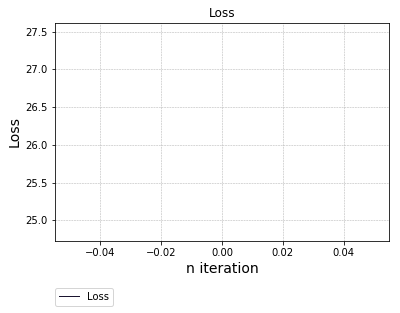

In [9]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Train without using the class

In [10]:
# Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
# TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?

for _ in range(100):
    net.zero_grad()
    loss = torch.zeros(1)
    prev_total_loss = 0

    batch_size = 1
    u_list = [None] * batch_size
    
    # Sample problem_instances
    problem_idx = np.random.choice(np.arange(nb_problem_instances), batch_size, replace = 0)

    for i in range(batch_size):

        idx = problem_idx[i]
        problem_instance = problem_instances_list[idx]
        
        B_idx = problem_instance.B_idx
        B = problem_instance.B
        f = problem_instance.forcing_term
        initial_u = problem_instance.initial_u
        k = problem_instance.k
        ground_truth = problem_instance.ground_truth
        
        # Compute the solution with the updated weights      
        u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)
        
        H = helpers.build_diagH_from_net(net,N)
        T = helpers.get_T(N)
        
        spectral_norm = helpers.calculate_spectral_radius(T,H)
        ex = 0
                
        if spectral_norm > 1:
            ex = np.nan_to_num(np.inf)

        # Define the loss, CHECK if it is correct wrt paper
        loss = loss + F.mse_loss(ground_truth, u_list[i])+ex
    


    # Backpropagation
    loss.backward(retain_graph =  False)

    # SGD step
    optim.step()
    
    total_loss = helpers.compute_loss(net, problem_instances_list,N)
    
    # Exit optimization 
    tol = 1e-2
    if total_loss.item() <= tol or total_loss.item() - prev_total_loss < tol:
        break


    # Store lossses for visualization
    losses.append(total_loss.item())
    prev_loss = total_loss.item()

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[ 0.2274, -0.0089, -0.1305],
          [ 0.0541,  0.2024, -0.0456],
          [ 0.2344, -0.1297,  0.3106]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.0194, -0.2598, -0.2926],
          [ 0.1117,  0.0224,  0.0932],
          [ 0.2278,  0.0886,  0.3332]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.2591, -0.1149, -0.0808],
          [-0.0338,  0.2629,  0.1549],
          [-0.2991, -0.1965, -0.1655]]]], requires_grad=True)


Plot the losses

final loss is 26.17232322692871


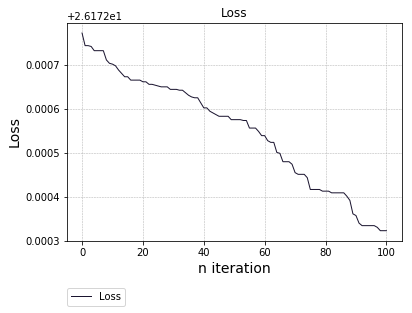

In [11]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [12]:
N = 50
nb_iters = 2000

B_idx, B = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

In [14]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)

In [50]:
%%timeit

u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = F.mse_loss(gtt, u_k_old)
k_count_old = 1
count_old = 1
# old method 
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = F.mse_loss(gtt, u_k_old)
    k_count_old += 1

820 ms ± 98.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit

u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = F.mse_loss(gtt, u_k_new)
k_count_new = 1


# new method

while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = F.mse_loss(gtt, u_k_new)
    k_count_new += 1

3.32 s ± 878 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

needed 1 iterations (compared to 1), ratio: 1.0


In [28]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

the loss of the new method is 164.0253448486328, compared to the pure-jacoby one: 39.881065368652344. computed with 2000 iterations


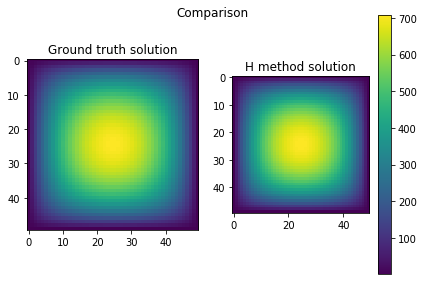

In [30]:
helpers.plot_solution(gtt,output,N)

In [31]:
(gtt.view(N,N) - output.view(N,N)).mean()

tensor(10.1657, grad_fn=<MeanBackward1>)

Test on L-shape domain

In [33]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

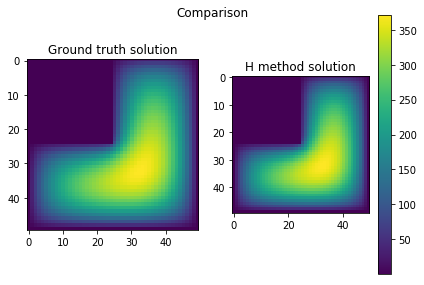

In [35]:
helpers.plot_solution(gtt,output,N)